In [6]:
data.Age.min()

0.0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxCC
from pycox.evaluation import EvalSurv

In [23]:
np.random.seed(111)
_ = torch.manual_seed(222)

In [24]:
# Dataset

path = "E:/Research/Ovarian Cancer/Articles/Orginal/"
data = pd.read_excel(path+"data_ready.xlsx")

df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [25]:
df_train.head()

,Age,Grading,Histology,Type,Status,MonthSurvive,YearSurvive
0,33.0,2.0,Undifferentiated,type_2,1.0,0,1
1,17.0,9.0,Undifferentiated,type_2,1.0,1,1
2,55.0,9.0,Serous carcinoma,type_2,1.0,0,1
5,72.0,9.0,Serous carcinoma,type_2,1.0,0,1
6,84.0,9.0,Serous carcinoma,type_2,1.0,3,1


In [26]:
# Feature transformers

cols_standardize = ['Age']
cols_onehotencoded = ['Grading', 'Histology', 'Type']

standardize = [([col], StandardScaler()) for col in cols_standardize]
onehot_encoded = [([col], OneHotEncoder(handle_unknown='ignore')) for col in cols_onehotencoded]

#encoded = [([col], LabelEncoder()) for col in cols_labelencoded]
#leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + onehot_encoded)

In [27]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [30]:
get_target = lambda df: (df['MonthSurvive'].values, df['Status'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [31]:
val.shapes()

((428, 27), ((428,), (428,)))

In [32]:
val.repeat(2).cat().shapes()

((856, 27), ((856,), (856,)))

In [33]:
# Neural Net

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [34]:
# Training the model

model = CoxCC(net, tt.optim.Adam)

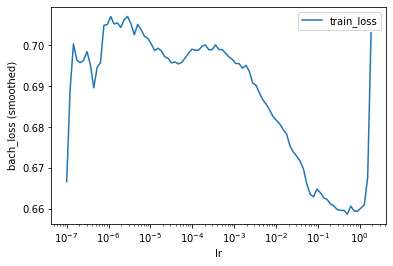

In [35]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [36]:
lrfinder.get_best_lr()

0.050941380148164093

In [37]:
model.optimizer.set_lr(0.01)

In [38]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [39]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.6504,	val_loss: 0.6386
1:	[0s / 0s],		train_loss: 0.6278,	val_loss: 0.6336
2:	[0s / 0s],		train_loss: 0.6200,	val_loss: 0.6210
3:	[0s / 0s],		train_loss: 0.6017,	val_loss: 0.6086
4:	[0s / 0s],		train_loss: 0.6035,	val_loss: 0.6002
5:	[0s / 0s],		train_loss: 0.6029,	val_loss: 0.5928
6:	[0s / 0s],		train_loss: 0.6137,	val_loss: 0.6195
7:	[0s / 0s],		train_loss: 0.5857,	val_loss: 0.6030
8:	[0s / 0s],		train_loss: 0.5917,	val_loss: 0.5996
9:	[0s / 0s],		train_loss: 0.5910,	val_loss: 0.5982
10:	[0s / 0s],		train_loss: 0.5956,	val_loss: 0.5976
11:	[0s / 0s],		train_loss: 0.5923,	val_loss: 0.5950
12:	[0s / 0s],		train_loss: 0.6103,	val_loss: 0.5907
13:	[0s / 0s],		train_loss: 0.5936,	val_loss: 0.6002
14:	[0s / 0s],		train_loss: 0.5966,	val_loss: 0.6140
15:	[0s / 0s],		train_loss: 0.5755,	val_loss: 0.5991
16:	[0s / 0s],		train_loss: 0.6080,	val_loss: 0.5968
17:	[0s / 0s],		train_loss: 0.6008,	val_loss: 0.5974
18:	[0s / 0s],		train_loss: 0.5850,	val_loss: 0.6009
19:

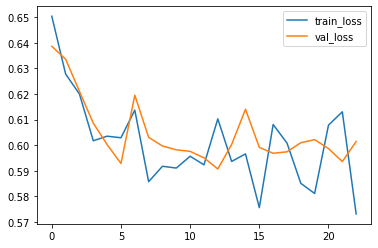

In [40]:
_ = log.plot()

In [41]:
model.partial_log_likelihood(*val).mean()

-5.518215179443359

In [42]:
# prediction

_ = model.compute_baseline_hazards()

In [43]:
surv = model.predict_surv_df(x_test)

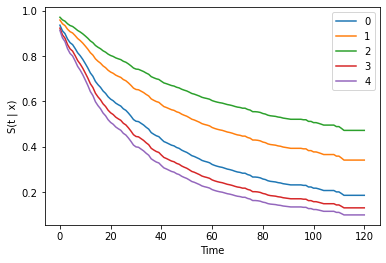

In [44]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [45]:
# evaluation

ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [46]:
ev.concordance_td()

0.6601156718513111

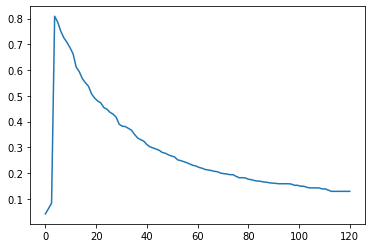

In [47]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [48]:
ev.integrated_brier_score(time_grid)

0.2852884500738522

In [49]:
ev.integrated_nbll(time_grid)

0.8028376450279665